<a href="https://colab.research.google.com/github/TeinkBR/1D_harmonic_oscillator/blob/main/Emulation_for_Infrared_extrapolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
In this notebook, we will explore how to use emulation technology to perform infrared extrapolation. 

# Training calculations
Some codes are from Jingyi's notebook

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
import pickle
#load interactive widgets
import ipywidgets as widgets
from scipy import interpolate
from math import exp,factorial                          #gaussian quadrature method                        
from scipy.special import hermite,gamma, loggamma

from sympy import diff, integrate, exp          
from scipy.misc import derivative              # import from scipy derivative 
# Import hermite polynomials and factorial to use in normalization factor
from scipy.special import hermite
#If your screen has retina display this will increase resolution of plots
%config InlineBackend.figure_format = 'retina'
import scipy.integrate as integrate
import scipy.special as special
from numpy import linalg as LA
from scipy.linalg import eigh
%matplotlib inline

In [ ]:
class truncation_scheme:
  def __init__(self,mesh,e_max,length, omega, hbar,mass):
  ### input variable 
    
    self.e_max=e_max      

    self.length=length     
    
    self.omega = omega  
    
    self.starting_position=-length/2 
  
    self.ending_position=length/2   
    
    self.mesh=mesh  
    
    self.hbar=hbar 
  
    self.mass=mass 
  
    self.scaling_factor_b=hbar/np.sqrt(mass*omega)
  
    self.meshpoint,self.weight = np.polynomial.legendre.leggauss(mesh) 

    self.meshpoint=self.length/2*self.meshpoint

    self.weight = self.length/2*self.weight

    self.energy_level=np.arange(0,self.e_max) 


In [ ]:
class basis_wave_function_class():
  def __init__(self,truncation_scheme):
    self.meshpoint=truncation_scheme.meshpoint
    self.weight = truncation_scheme.weight
    self.energy_level = truncation_scheme.energy_level
    self.e_max = truncation_scheme.e_max
    ### harmonic wave function used for our basis
    self.basis_wave_function_ilevel_ix = np.zeros((self.e_max,len(self.meshpoint)))     
    for i in self.energy_level:
      self.basis_wave_function_ilevel_ix[i]=1./np.sqrt(np.sqrt(np.pi))\
             *np.exp(-0.5*(i*np.log(2) + loggamma(i + 1.) + self.meshpoint**2) ) * hermite(i)(self.meshpoint)


In [ ]:
mesh=1000
e_max=100
length=60
omega=35
hbar=197.3
mass=940
alpha=0.5
lambda_coeff=2
V_0=50

In [ ]:
truncation_scheme_1 = truncation_scheme(mesh,e_max,length,omega,hbar,mass)

In [ ]:
basis_wave_function_1 = basis_wave_function_class(truncation_scheme_1)

/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:128: RuntimeWarning: invalid value encountered in sqrt
  mu = sqrt(hn)


In [ ]:
### the following is the normalization of the HO's states
for i in truncation_scheme_1.energy_level:
  print(f'the normlization of state {i}: {basis_wave_function_1.basis_wave_function_ilevel_ix[i]**2 @ truncation_scheme_1.weight}')

the normlization of state 0: 1.0000000000001035
the normlization of state 1: 1.0000000000001046
the normlization of state 2: 1.0000000000001044
the normlization of state 3: 1.000000000000105
the normlization of state 4: 1.000000000000104
the normlization of state 5: 1.0000000000001048
the normlization of state 6: 1.0000000000001052
the normlization of state 7: 1.0000000000001055
the normlization of state 8: 1.0000000000001046
the normlization of state 9: 1.000000000000104
the normlization of state 10: 1.0000000000001044
the normlization of state 11: 1.0000000000001052
the normlization of state 12: 1.000000000000108
the normlization of state 13: 1.000000000000107
the normlization of state 14: 1.0000000000001008
the normlization of state 15: 1.0000000000000981
the normlization of state 16: 1.000000000000104
the normlization of state 17: 1.000000000000099
the normlization of state 18: 1.0000000000001088
the normlization of state 19: 1.0000000000001041
the normlization of state 20: 1.00000

In [ ]:
class Hamiltonian_class:
  def __init__(self,truncation_scheme, V_s_func_of_x_unscaled, test_r_sqr_included = True ):  
    ### setting Hamiltonian Numerical space
    ### Kinetic term + Potential Term + Harmonic oscillator trap
    self.truncation_scheme = truncation_scheme 
    self.hbar = truncation_scheme.hbar
    self.mass = truncation_scheme.mass
    self.omega = truncation_scheme.omega 
    self.meshpoint=truncation_scheme.meshpoint
    self.weight = truncation_scheme.weight
    self.energy_level = truncation_scheme.energy_level
    self.e_max = truncation_scheme.e_max
    self.basis_wave_function_ilevel_ix  = basis_wave_function_class(truncation_scheme).basis_wave_function_ilevel_ix
    self.scaling_factor_b= truncation_scheme.scaling_factor_b 

    self.H_p_sqr=np.zeros((self.e_max,self.e_max))
    self.H_r_sqr=np.zeros((self.e_max,self.e_max))

    ## this is the potential on the x mesh after rescsling
    self.V_s_ix = np.array([ V_s_func_of_x_unscaled(x*self.scaling_factor_b)/self.omega 
                            for x in self.meshpoint]) 
    
    self.V_s_ilevel_ilevel = [[(self.weight*self.basis_wave_function_ilevel_ix[i] 
                                * self.V_s_ix) 
                                       @(self.basis_wave_function_ilevel_ix[j])  
                              for j in self.energy_level]  
                              for i in self.energy_level]
    
  ### integration using numerical gaussian quadrature 

   ### Now we set Hamiltonian P square and R square values from the book of Quantum Mechanics By Griffith     
   ### i & j here are the energy level of the psi and psi conjugate <psi|H|psi>, formula from the textbook 
   ### mentioned above, see overleaf file

    for i in range(self.e_max):
     for j in range(self.e_max):   
        if (i == j) :
          self.H_p_sqr[i][j]= 0.25*(2*j+1)
          self.H_r_sqr[i][j] = 0.25*(2*j+1)
          
        elif (i == j-2):
           
          self.H_p_sqr[i][j]= -0.25*np.sqrt(j*(j-1))
          self.H_r_sqr[i][j] = 0.25*np.sqrt(j*(j-1))

            
        elif (i == j+2):
           
          self.H_p_sqr[i][j]= -0.25*np.sqrt((j+2)*(j+1))
          self.H_r_sqr[i][j] = 0.25*np.sqrt((j+2)*(j+1))
            
        else:
          
          self.H_p_sqr[i][j]=  0
          self.H_r_sqr[i][j]=  0

     ### Total H include Potential V + Kinetic T + Harmonic Oscillator Trap R_squared

    if test_r_sqr_included:
          self.Total_H= self.V_s_ilevel_ilevel +self.H_p_sqr+self.H_r_sqr
    else : 
      self.Total_H= self.V_s_ilevel_ilevel +self.H_p_sqr 
   
     ### getting eigenvalue(energy) and eigenvector(wavefunction) from the hamiltonian
    self.eigenval_iHlevel,self.psi_iHOlevel_iHlevel =LA.eigh(self.Total_H)
     ### same thing, but computed from numerical Total H, might not be useful
    
     ## <Phi|psi>, for plotting
    self.psi_iHlevel_ix = self.psi_iHOlevel_iHlevel.T @ self.basis_wave_function_ilevel_ix

    

Define the strong interaction potential function

In [ ]:
class PT_pot_class:
  def __init__(self, hbar, mass, alpha, lambda_coeff):
    self.hbar = hbar 
    self.mass = mass 
    self.alpha = alpha 
    self.lambda_coeff= lambda_coeff 
    self.eigenE_ifullH_analy = - (self.hbar*self.alpha*(self.lambda_coeff-1-np.arange(0,e_max)))**2/(2*self.mass)

  def V_s_func_of_x_unscaled(self, x):
    return  -(self.alpha*self.hbar)**2/(2*self.mass) *self.lambda_coeff*(
      self.lambda_coeff-1)/(np.cosh(self.alpha* x )**2)


In [ ]:
alpha, lambda_coeff

(0.5, 2)

In [ ]:
x_unscaled_list = np.linspace(-5,5,100)
PT_pot_1 = PT_pot_class(hbar, mass, alpha, lambda_coeff)

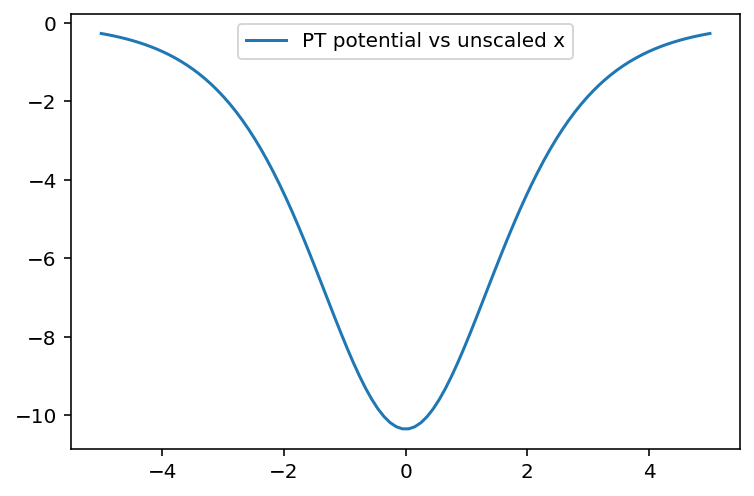

In [ ]:
plt.plot(x_unscaled_list, PT_pot_1.V_s_func_of_x_unscaled(x_unscaled_list) , label = 'PT potential vs unscaled x')
plt.legend(loc = 'best')
plt.show()

# Test the training calculations codes for PT potential 

In [ ]:
H_class_for_PT_pot_1  =  Hamiltonian_class(truncation_scheme_1 , PT_pot_1.V_s_func_of_x_unscaled, test_r_sqr_included=False)

/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:128: RuntimeWarning: invalid value encountered in sqrt
  mu = sqrt(hn)


In [ ]:
H_class_for_PT_pot_1.eigenval_iHlevel*omega 

array([-5.17649305e+00,  2.78973617e-01,  1.11336422e+00,  2.43442990e+00,
        4.29467104e+00,  6.52457770e+00,  9.34511146e+00,  1.24135764e+01,
        1.61812254e+01,  2.00541369e+01,  2.47775942e+01,  2.94338256e+01,
        3.51301446e+01,  4.05535541e+01,  4.72437109e+01,  5.34204643e+01,
        6.11278638e+01,  6.80454422e+01,  7.67954014e+01,  8.44421846e+01,
        9.42617778e+01,  1.02626848e+02,  1.13544904e+02,  1.22617944e+02,
        1.34665117e+02,  1.44436344e+02,  1.57645231e+02,  1.68105363e+02,
        1.82510649e+02,  1.93650870e+02,  2.09289504e+02,  2.21101449e+02,
        2.38012847e+02,  2.50488583e+02,  2.68714856e+02,  2.81846868e+02,
        3.01433089e+02,  3.15214271e+02,  3.36208772e+02,  3.50632423e+02,
        3.73087139e+02,  3.88146950e+02,  4.12117813e+02,  4.27807870e+02,
        4.53355259e+02,  4.69670038e+02,  4.96859306e+02,  5.13793673e+02,
        5.42695748e+02,  5.60244967e+02,  5.90937062e+02,  6.09096795e+02,
        6.41663242e+02,  

In [ ]:
PT_pot_1.eigenE_ifullH_analy

array([-5.17650133e+00, -0.00000000e+00, -5.17650133e+00, -2.07060053e+01,
       -4.65885120e+01, -8.28240213e+01, -1.29412533e+02, -1.86354048e+02,
       -2.53648565e+02, -3.31296085e+02, -4.19296608e+02, -5.17650133e+02,
       -6.26356661e+02, -7.45416191e+02, -8.74828725e+02, -1.01459426e+03,
       -1.16471280e+03, -1.32518434e+03, -1.49600888e+03, -1.67718643e+03,
       -1.86871698e+03, -2.07060053e+03, -2.28283709e+03, -2.50542664e+03,
       -2.73836920e+03, -2.98166477e+03, -3.23531333e+03, -3.49931490e+03,
       -3.77366947e+03, -4.05837704e+03, -4.35343762e+03, -4.65885120e+03,
       -4.97461778e+03, -5.30073736e+03, -5.63720995e+03, -5.98403554e+03,
       -6.34121413e+03, -6.70874572e+03, -7.08663032e+03, -7.47486792e+03,
       -7.87345852e+03, -8.28240213e+03, -8.70169874e+03, -9.13134835e+03,
       -9.57135096e+03, -1.00217066e+04, -1.04824152e+04, -1.09534768e+04,
       -1.14348914e+04, -1.19266591e+04, -1.24287797e+04, -1.29412533e+04,
       -1.34640800e+04, -

In [ ]:
e_max_list = np.arange(20,80,20) 
omega_list = np.arange(1,110,10) 
gs_E_iemax_iomega = np.zeros((len(e_max_list), len(omega_list)))
for iemax, e_max in enumerate(e_max_list):
  for iomega, omega in enumerate(omega_list): 
    truncation_scheme_tp = truncation_scheme(mesh,e_max,length,omega,hbar,mass)
    H_class_for_PT_pot_tp  =  Hamiltonian_class(truncation_scheme_tp , PT_pot_1.V_s_func_of_x_unscaled, test_r_sqr_included=False)
    gs_E_iemax_iomega[iemax, iomega] = H_class_for_PT_pot_tp.eigenval_iHlevel[0]*omega 


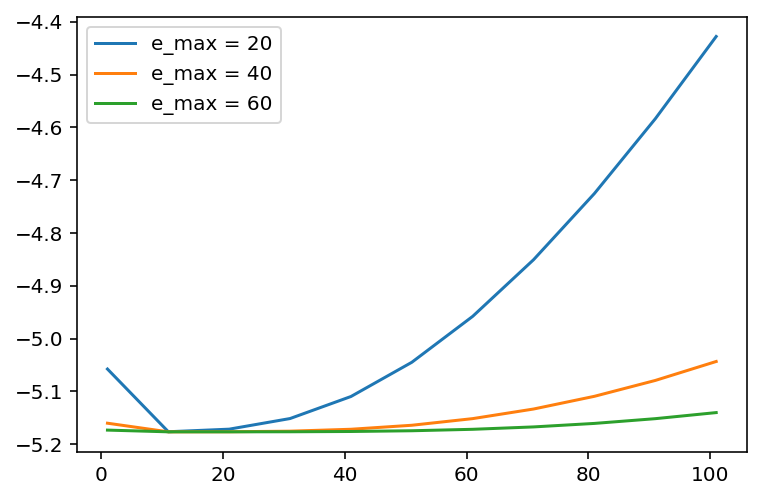

In [ ]:
for iemax, e_max in enumerate(e_max_list):
  plt.plot(omega_list, gs_E_iemax_iomega[iemax], label = f'e_max = {e_max}' )
#plt.yscale('log')
plt.legend()
plt.show()

# Construct a list of training Hamiltonian classes based on PT potential



In [ ]:
omega_training_list = np.array( [30,30.5, 31] )
e_max_training = 100
print(f'length={length}, mesh= {mesh}')

length=60, mesh= 1000


In [ ]:
H_class_training_list =  []
for omega in omega_training_list : 
  truncation_scheme_tp = truncation_scheme(mesh,e_max_training,length,omega,hbar,mass)
  H_class_training_list.append(Hamiltonian_class(truncation_scheme_tp, PT_pot_1.V_s_func_of_x_unscaled, test_r_sqr_included=True) )

/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:128: RuntimeWarning: invalid value encountered in sqrt
  mu = sqrt(hn)


# Emulation

In [ ]:
class emulation:
  def __init__(self,training_list):
    
    self.training_list = training_list     
    self.hbar= self.training_list[0].hbar
    self.mass=self.training_list[0].mass
    self.e_max=self.training_list[0].e_max
    self.meshpoint= self.training_list[0].meshpoint
    self.weight = self.training_list[0].weight
    self.basis_wave_function_ilevel_ix = self.training_list[0].basis_wave_function_ilevel_ix 
    self.energy_level = self.training_list[0].energy_level
    self.N_matrix=[[np.conj(
            class_left.psi_iHOlevel_iHlevel[:,0]) @ class_right.psi_iHOlevel_iHlevel[:, 0] 
            for j,class_right in enumerate(self.training_list)] 
            for i,class_left in enumerate(self.training_list)]

    ## The sum of the p^2 and r^2 pieces in H
    self.H_p_sqr_r_sqr_ilevel_ilevel = training_list[0].H_p_sqr+ training_list[0].H_r_sqr

  def start_emu(self,emulation_omega, emulation_V_s_func_of_x_unscaled):
    ## this is the potential on the x mesh after rescsling
    scaling_factor_b = self.hbar/np.sqrt(mass*emulation_omega)
    V_s_ix = np.array([ emulation_V_s_func_of_x_unscaled(x*scaling_factor_b)/emulation_omega 
                            for x in self.meshpoint]) 
    
    V_s_ilevel_ilevel = [[(self.weight*self.basis_wave_function_ilevel_ix[i] 
                                * V_s_ix) 
                                       @(self.basis_wave_function_ilevel_ix[j])  
                              for j in self.energy_level]  
                              for i in self.energy_level]

    emulation_H= self.H_p_sqr_r_sqr_ilevel_ilevel + V_s_ilevel_ilevel

    self.H_matrix=[[np.conj(
            class_left.psi_iHOlevel_iHlevel[:,0]) @ emulation_H @ class_right.psi_iHOlevel_iHlevel[:, 0] 
            for j, class_right in enumerate(self.training_list)] 
            for i,class_left in enumerate(self.training_list)]
    
    eigval_emu_H, eigvec_emu_H = eigh(self.H_matrix,self.N_matrix)
    print('shape of eigvec emulation', np.shape(eigvec_emu_H[0,:]))
    #print('shape of ')
    emu_psi=eigvec_emu_H[:,0]@[class_training.psi_iHlevel_ix[0] for i_class_traing,class_training in enumerate(self.training_list)]
    normalization_emu = emu_psi**2@self.weight
    return eigval_emu_H,eigvec_emu_H, V_s_ix,emu_psi,normalization_emu

In [ ]:
my_emul = emulation(H_class_training_list)

start emulation

In [ ]:
#emulation_omega_list = np.arange(1e-1,100, 2)
emulation_omega_list=np.array([1e-2,1e-1,1])

emulation_V_s_func_of_x_unscaled = PT_pot_1.V_s_func_of_x_unscaled
emulation_gs_E_list = emulation_omega_list * 0. 
gs_E_from_fullcalculation_list = emulation_gs_E_list + 1.
V_s_ix_iemu = [] 
e_max_for_fullcalclation = e_max_training

full_calculation_class_list=np.empty(len(emulation_omega_list),dtype=object)
my_emu_start_emu_list=np.empty(len(emulation_omega_list),dtype=object)
emulation_psi_list=[]
normalization_emu_list=[]
for i, emulation_omega in enumerate(emulation_omega_list):
  truncation_scheme_tp = truncation_scheme(mesh,e_max_for_fullcalclation,length,emulation_omega,hbar,mass)
  H_class_for_PT_pot_tp  =  Hamiltonian_class(truncation_scheme_tp , PT_pot_1.V_s_func_of_x_unscaled, test_r_sqr_included=False)
 
  ### emulation omega list
  ### get emulation psi 
  eigval_emu_H,eigvec_emu_H, V_s_ix,emu_psi,normalization_emu  = my_emul.start_emu(emulation_omega, emulation_V_s_func_of_x_unscaled)
  emulation_psi_list.append(emu_psi)
  normalization_emu_list.append(normalization_emu)
  emulation_gs_E_list[i] = eigval_emu_H[0]*emulation_omega
  V_s_ix_iemu.append(V_s_ix)
  truncation_scheme_tp = truncation_scheme(mesh,e_max_for_fullcalclation,length,emulation_omega,hbar,mass)
  full_calculation_class_list[i]= Hamiltonian_class(truncation_scheme_tp, PT_pot_1.V_s_func_of_x_unscaled,
                                                       test_r_sqr_included=True)  
  #plt.plot(truncation_scheme_tp.meshpoint,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in cosh
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


shape of eigvec emulation (3,)
shape of eigvec emulation (3,)
shape of eigvec emulation (3,)


In [ ]:
normalization_emu_list

[1.0001537326829575, 1.0001332290563367, 1.0000408511610908]

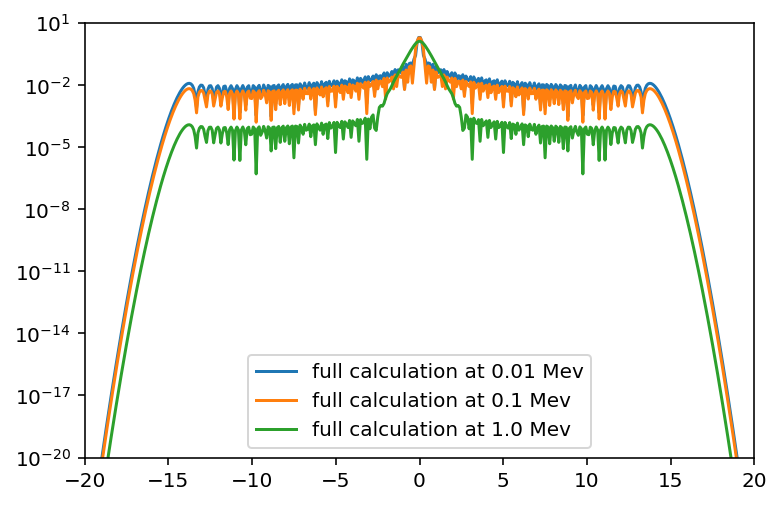

In [ ]:
for i, emulation_omega in enumerate(emulation_omega_list):
  plt.plot(truncation_scheme_tp.meshpoint,np.absolute(full_calculation_class_list[i].psi_iHlevel_ix[0]),label=fr'full calculation at {emulation_omega} Mev')

plt.yscale('log')
plt.ylim(1e-20,10)
plt.xlim(-20,20)
plt.legend()
plt.show()

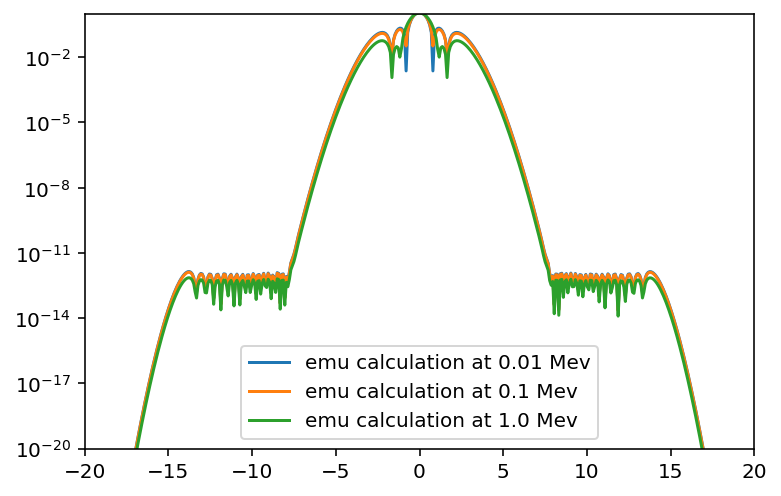

In [ ]:
for i, emulation_omega in enumerate(emulation_omega_list):
  plt.plot(truncation_scheme_tp.meshpoint,np.absolute(emulation_psi_list[i]),label=fr'emu calculation at {emulation_omega} Mev')

plt.yscale('log')
plt.ylim(1e-20,1)
plt.xlim(-20,20)
plt.legend()
plt.show()

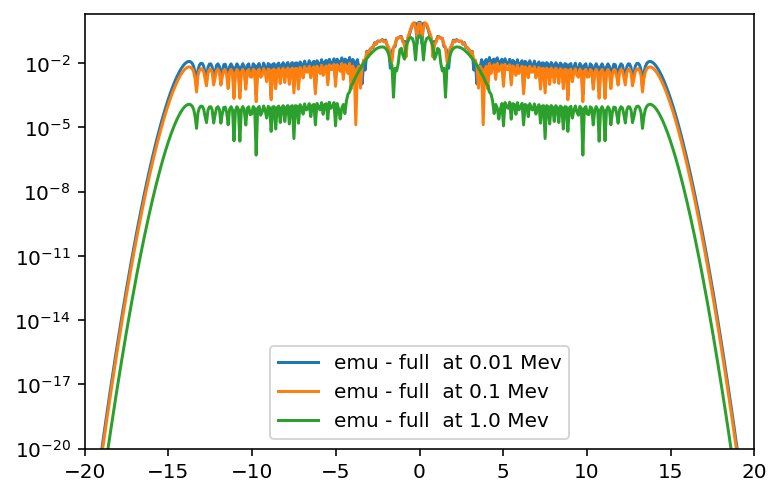

In [ ]:
for i, emulation_omega in enumerate(emulation_omega_list):
  plt.plot(truncation_scheme_tp.meshpoint,np.absolute(np.absolute(emulation_psi_list[i])-np.absolute(full_calculation_class_list[i].psi_iHlevel_ix[0])),label=fr'emu - full  at {emulation_omega} Mev')

plt.yscale('log')
plt.ylim(1e-20,2)
plt.xlim(-20,20)
plt.legend()
plt.show()

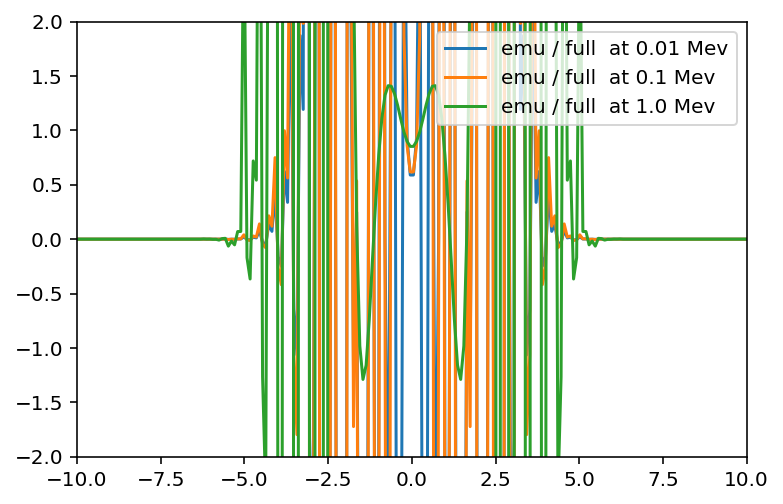

In [ ]:
for i, emulation_omega in enumerate(emulation_omega_list):
  plt.plot(truncation_scheme_tp.meshpoint,emulation_psi_list[i]/full_calculation_class_list[i].psi_iHlevel_ix[0],label=fr'emu / full  at {emulation_omega} Mev')

#plt.yscale('log')
plt.ylim(-2,2)
plt.xlim(-10,10)
plt.legend()
plt.show()

In [ ]:
full_calculation_class_list[0].e_max

100

In [ ]:
truncation_scheme_tp.length

60

In [ ]:
eigval_emu_H_1,eigvec_emu_H_1, V_s_ix_1=my_emul.start_emu(1e-1, emulation_V_s_func_of_x_unscaled)

shape of eigvec emulation (3,)


ValueError: ignored

In [ ]:
np.shape(basis_wave_function_1.basis_wave_function_ilevel_ix)

In [ ]:
np.shape(eigvec_emu_H_1.T)

In [ ]:
H_class_training_list_wave_function=np.zeros((len(H_class_training_list),len(basis_wave_function_1.basis_wave_function_ilevel_ix[0,:])))

In [ ]:
np.shape(H_class_training_list_wave_function)

In [ ]:
for i,i_H_class in enumerate(H_class_training_list):
  
  H_class_training_list_wave_function[i,:]=i_H_class.basis_wave_function_ilevel_ix[0,:]





In [ ]:
np.shape(H_class_training_list_wave_function)

In [ ]:
np.shape((eigvec_emu_H_1.T@H_class_training_list_wave_function)[0])

In [ ]:
#for i,i_wave_function in enumerate(H_class_training_list_wave_function):
plt.plot(truncation_scheme_1.meshpoint,np.absolute((eigvec_emu_H_1.T@H_class_training_list_wave_function)[i]-H_class_for_PT_pot_1.psi_iHlevel_ix[0]))
plt.legend()
plt.yscale('log')
plt.show()
  ### 

In [ ]:
plt.plot(emulation_omega_list, np.absolute(emulation_gs_E_list - PT_pot_1.eigenE_ifullH_analy[0]), label = 'emulation - analy w/o r^2')
plt.plot(emulation_omega_list, np.absolute(emulation_gs_E_list - gs_E_from_fullcalculation_list), label = 'emulation - full')
plt.plot(emulation_omega_list, np.absolute(gs_E_from_fullcalculation_list- PT_pot_1.eigenE_ifullH_analy[0]), label = 'full - analy w/o r^2')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
plt.plot(emulation_omega_list, emulation_gs_E_list, label = 'emulation ')
plt.plot(emulation_omega_list, gs_E_from_fullcalculation_list, label = 'full')
plt.legend()

plt.show()

In [ ]:
plt.plot(truncation_scheme_1.meshpoint, V_s_ix_iemu[10], label = 'rescaled potential')
plt.xlim(-2,2)
plt.legend()
plt.show()